In [1]:
import numpy as np
import pandas as pd 

from tensorflow import keras

import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
from tqdm.keras import TqdmCallback

In [2]:
df = pd.read_csv('AB_NYC_2019.csv', nrows=20000)

In [3]:
numerical = [
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

In [4]:
df[numerical] = df[numerical].fillna(0)

df.name = df.name.fillna('')
df.neighbourhood_group = df.neighbourhood_group.str.lower().str.replace(' ', '_').fillna('NA')
df.neighbourhood = df.neighbourhood.str.lower().str.replace(' ', '_').fillna('NA')
df.room_type = df.room_type.str.lower().str.replace(' ', '_').fillna('NA')

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_train, df_val = train_test_split(df)

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin

In [15]:
from sklearn.preprocessing import StandardScaler

In [8]:
class ConcatenatingTranformer(TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        columns = list(X.columns)
        
        res = ''
        
        for c in columns:
            res = res + ' ' + c + '=' + X[c]

        return res.str.strip()

In [16]:
transformations = [
    ('numerical', StandardScaler(), numerical),
    ('categories', Pipeline([
        ('concatenate', ConcatenatingTranformer()),
        ('vectorize', CountVectorizer(token_pattern='\S+', min_df=100))
    ]), ['neighbourhood', 'neighbourhood_group', 'room_type']),
    ('name', CountVectorizer(min_df=100, dtype='int32'), 'name')
]

tranformer = ColumnTransformer(transformations, remainder='drop')

In [17]:
X_train = tranformer.fit_transform(df_train)
X_val = tranformer.transform(df_val)

In [19]:
X_train

<15000x183 sparse matrix of type '<class 'numpy.float64'>'
	with 207901 stored elements in Compressed Sparse Row format>

In [14]:
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)

Linear regression with keras

In [40]:
inputs = keras.layers.Input(shape=(183,))

outputs = keras.layers.Dense(1)(inputs)

model = keras.Model(inputs, outputs)

learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.MeanSquaredError()
rmse = keras.metrics.RootMeanSquaredError()

model.compile(optimizer=optimizer, loss=loss, metrics=[rmse])

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=100, 
    verbose=0,
    validation_data=(X_val, y_val),
    callbacks=[TqdmCallback()]
)

Add more layers

In [48]:
inputs = keras.layers.Input(shape=(183,))

## added this:
inner = keras.layers.Dense(30, activation='relu')(inputs)
drop = keras.layers.Dropout(0.2)(inner)

outputs = keras.layers.Dense(1)(drop)

model = keras.Model(inputs, outputs)



learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.MeanSquaredError()
rmse = keras.metrics.RootMeanSquaredError()

model.compile(optimizer=optimizer, loss=loss, metrics=[rmse])

In [49]:
history = model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=30, 
    verbose=0,
    validation_data=(X_val, y_val),
    callbacks=[TqdmCallback()]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

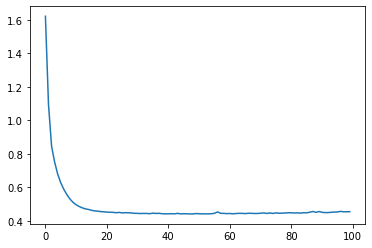

In [47]:
plt.plot(history.history['val_root_mean_squared_error'])

Sequential

In [61]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

In [62]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.MeanSquaredError()
rmse = keras.metrics.RootMeanSquaredError()

model.compile(optimizer=optimizer, loss=loss, metrics=[rmse])

In [63]:
history = model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=30, 
    verbose=0,
    validation_data=(X_val, y_val),
    callbacks=[TqdmCallback()]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [64]:
pred = model.predict(X_train[:10])

In [65]:
pred

array([[4.975269 ],
       [5.188339 ],
       [4.079772 ],
       [4.6929116],
       [4.1848497],
       [4.9689226],
       [4.9001856],
       [4.0081806],
       [4.8581057],
       [3.9850411]], dtype=float32)